# This notebook creates a simple Q-Learning AI_trader from scratch

In [338]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

The AI_trader needs to be told:

* What information can we look at?
* What actions are available?
* What states can we be in?
* How fast should it learn?
* How much more valuable is instant gratification?

At each time step:

1. Train a model on all timesteps up to that point
2. Get the "state" from the model (**state** will be the binned probability of an up-move)
3. Decide on the best **action** (or take an action at random)
4. Receive **reward**
5. Update the **q-table**
6. Go to next timestep

The model:

* Random Forest model, uses the last 25 daily pct_changes to predict if the next one will be positive or negative
* Predict the probability of an up-move, then put the probability in the proper bin:
    * 0-0.1999 $\implies$ State = 0
    * 0.2 - 0.3999 $\implies$ State = 1
    * 0.4 - 0.5999 $\implies$ State = 2
    * 0.6 - 0.7999 $\implies$ State = 3
    * 0.8 - 1 $\implies$ State = 4
    
For this one, the only thing we care about is that the AI_trader not lose money. 
* If *profit* $\ge$ 0, **reward** = 1
* otherwise **reward** = -1

In [529]:
class AI_trader():
    
    def __init__(self, df, state_list, action_list, learning_rate, discount_rate, random_rate, lookback_window, commission):
        self.df = df
        self.time = lookback_window*2 - 1
        self.Close = df['Close'][:lookback_window*2]
        self.Open = df['Open'][:lookback_window*2]
        self.state_list = state_list
        self.action_list = action_list
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.lookback_window = lookback_window
        self.commission = commission
        self.value_over_time = [10000]
        self.times_through = 0
        self.random_rate = random_rate
        
        self.q_table = np.zeros((len(state_list), len(action_list)))
        
    def build_model(self):
        df_sliced = []
        for i in range(lookback_window, len(self.Close)):
            df_sliced.append(self.Close[i-lookback_window:i])
            
        self.df_sliced_array = np.array(df_sliced)
        
        y = []
        for i in range(lookback_window, len(self.Close)-1):
            y.append(self.Close[i] - self.Close[i-1])
        y_array = np.array(y)
        y_binary = (y_array > 0) * 1
        
        self.model = RandomForestClassifier()
        self.model.fit(self.df_sliced_array[:-1], y_binary)
        
    def get_state(self):
        prob_up = self.model.predict_proba(self.df_sliced_array[-1].reshape(1,-1))[0][1]
        if prob_up < 0.2:
            self.state = 0
        elif prob_up < 0.4:
            self.state = 1
        elif prob_up < 0.6:
            self.state = 2
        elif prob_up < 0.8:
            self.state = 3
        else:
            self.state = 4
            
    def get_action(self):
        if np.random.rand() < self.random_rate:
            self.action = np.random.choice(self.action_list)
        else:
            q_s = self.q_table[self.state,:]
            where = np.where(q_s == np.max(q_s))[0]
            self.action = self.action_list[np.random.choice(where)]
            
    def step_forward(self):
        self.time += 1
            
    def get_next_open(self):
        self.Open[self.time] = self.df['Open'][self.time]
        
    def take_action(self):
        if self.action == 0:
            self.value = -self.Open[self.time] * (1 + self.commission)
        elif self.action == 1:
            self.value =  self.Open[self.time] * (1 - self.commission)
        else:
            self.value = 0
    
    def get_next_close(self):
        self.Close[self.time] = self.df['Close'][self.time]
    
    def get_reward(self):
        
        if self.value < 0:
            self.value += self.Close[self.time] * (1 - self.commission)
        elif self.value > 0:
            self.value -= self.Close[self.time] * (1 + self.commission)
        
        if self.value > 0:
            self.reward = 1
        elif self.value < 0:
            self.reward = -1
        else:
            self.reward = 0
            
        self.value_over_time.append(self.value_over_time[-1] + self.value)

    def update_qtable(self):
        self.q_table[self.state, self.action] = self.q_table[self.state, self.action] + learning_rate * (self.reward)
        
    def trade(self):
        self.step_forward()
        self.build_model()
        self.get_state()
        self.get_action()
        self.get_next_open()
        self.take_action()
        self.get_next_close()
        self.get_reward()
        self.update_qtable()
    
    def reset(self, name):
        self.times_through += 1
        data_out = {
            "learning_rate":self.learning_rate,
            "discount_rate":self.discount_rate,
            "lookback_window":lookback_window,
            "random_rate":self.random_rate,
            "commission":commission,
            "q_table":self.q_table.tolist(),
            "value_over_time":self.value_over_time
        }
        with open(name + str(self.times_through)+ ".json", "w") as outfile: 
            json.dump(data_out, outfile)
        
        self.df = df
        self.time = lookback_window*2 - 1
        self.Close = df['Close'][:lookback_window*2]
        self.Open = df['Open'][:lookback_window*2]
        self.state_list = state_list
        self.action_list = action_list
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.lookback_window = lookback_window
        self.commission = commission
        self.value_over_time = [10000]
        
        

In [530]:
df = pd.read_csv('BTC-USD.csv')
df.dropna(inplace=True)
df = df.reset_index()
df

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2020-01-29,9357.470703,9406.431641,9269.467773,9316.629883,9316.629883,3.068260e+10
1,1,2020-01-30,9316.016602,9553.125977,9230.897461,9508.993164,9508.993164,3.237879e+10
2,2,2020-01-31,9508.313477,9521.706055,9230.776367,9350.529297,9350.529297,2.943249e+10
3,3,2020-02-01,9346.357422,9439.323242,9313.239258,9392.875000,9392.875000,2.592266e+10
4,4,2020-02-02,9389.820313,9468.797852,9217.824219,9344.365234,9344.365234,3.083574e+10
...,...,...,...,...,...,...,...,...
357,361,2021-01-24,32064.376953,32944.007813,31106.685547,32289.378906,32289.378906,4.864383e+10
358,362,2021-01-25,32285.798828,34802.742188,32087.787109,32366.392578,32366.392578,5.989705e+10
359,363,2021-01-26,32358.613281,32794.550781,31030.265625,32569.849609,32569.849609,6.025542e+10
360,364,2021-01-27,32564.029297,32564.029297,29367.138672,30432.546875,30432.546875,6.257676e+10


In [531]:
state_list = [0, 1, 2, 3, 4]
action_list = [0, 1, 2]
learning_rate = 0.2
discount_rate = 0.9
random_rate = 0.1
lookback_window = 5
commission = 0

In [532]:
Trade_bot = AI_trader(df, state_list, action_list, learning_rate, discount_rate, random_rate, lookback_window, commission)

In [704]:
for i in range(df.shape[0] - (lookback_window * 2) - 1):
        Trade_bot.trade()

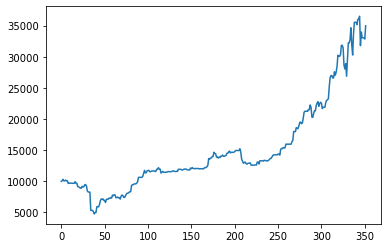

In [705]:
plt.plot(Trade_bot.value_over_time)

In [706]:
Trade_bot.time

360

In [707]:
Trade_bot.q_table

array([[  3.2,  -0.6,   0. ],
       [ 90.8, -17.4,   0. ],
       [ 34.2,  -8. ,   0. ],
       [ -0.8,  -1.2,   0. ],
       [ -1.2,   5.2,   0. ]])

In [708]:
whole_return = (Trade_bot.value_over_time[-1] - Trade_bot.value_over_time[0]) / Trade_bot.value_over_time[0]
print("Total Return: ", whole_return)

avg_daily_return = pd.DataFrame(Trade_bot.value_over_time).pct_change().mean()[0]
print('Average Daily Return: ', avg_daily_return)

sd_returns = pd.DataFrame(Trade_bot.value_over_time).pct_change().std()[0]
print('St. Dev. of Daily Returns: ', sd_returns)

sharpe_ratio = avg_daily_return / sd_returns
print("Sharpe Ratio: ", sharpe_ratio)

Total Return:  2.497285155500003
Average Daily Return:  0.004246567883320582
St. Dev. of Daily Returns:  0.03530985153788981
Sharpe Ratio:  0.1202658096356971


In [699]:
Trade_bot.reset(name='Trade_bot')

In [700]:
Trade_bot.time

9

In [701]:
Trade_bot.times_through

20

In [702]:
Trade_bot.random_rate = 0

In [703]:
Trade_bot.random_rate

0

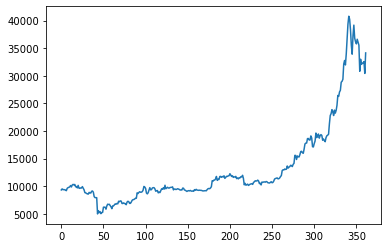

In [709]:
plt.plot(df['Close'])

In [719]:
whole_return = (df.loc[df.shape[0]-1, 'Close'] - df.loc[0, 'Close']) / df.loc[0, 'Close']
print("Total Return: ", whole_return)

avg_daily_return = pd.DataFrame(df['Close']).pct_change().mean()[0]
print('Average Daily Return: ', avg_daily_return)

sd_returns = pd.DataFrame(df['Close']).pct_change().std()[0]
print('St. Dev. of Daily Returns: ', sd_returns)

sharpe_ratio = avg_daily_return / sd_returns
print("Sharpe Ratio: ", sharpe_ratio)

Total Return:  2.665163173682339
Average Daily Return:  0.004480565381380141
St. Dev. of Daily Returns:  0.040522713514986874
Sharpe Ratio:  0.11056923371439707
